## Aggregating and extracting data from RDBMS

#### Connecting to RDBMS, using SQL to aggregate the data and retrieve the aggreagted data into a pandas dataframe for farther processing

#### Tags:
    Data: labeled data, Kaggle competition
    Technologies: python, pandas, sqlite
    Techniques: connecting to an RDBMS, aggregating and retrieving data 
    
#### Resources:
[SQLite Homepage](https://sqlite.org/about.html)

[DB Browser for SQLite](https://sqlitebrowser.org/)



In [6]:
import pandas as pd
import sqlite3 as lite
%matplotlib inline  

In [7]:
'''
With pandas we can import the data from e.g. a .csv file and then store it into a sqlite db table. 
'''

births = pd.read_csv('../data/births.csv')
# Data taken from: https://www.kaggle.com/xvivancos/barcelona-data-sets#births.csv

births.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 7 columns):
Year                 734 non-null int64
District Code        734 non-null int64
District Name        734 non-null object
Neighborhood Code    734 non-null int64
Neighborhood Name    734 non-null object
Gender               734 non-null object
Number               734 non-null int64
dtypes: int64(4), object(3)
memory usage: 40.2+ KB


In [8]:
births.head()

,Year,District Code,District Name,Neighborhood Code,Neighborhood Name,Gender,Number
0,2017,1,Ciutat Vella,1,el Raval,Boys,283
1,2017,1,Ciutat Vella,2,el Barri Gòtic,Boys,56
2,2017,1,Ciutat Vella,3,la Barceloneta,Boys,51
3,2017,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera",Boys,90
4,2017,2,Eixample,5,el Fort Pienc,Boys,117


In [20]:
# connect to the local SQLite db

con = lite.connect('../data/test.db')
cur = con.cursor()

#### Understanding the data set better

We want to understand the relationships in the data batter, so we would like to answer these questions

* How many children was born in the period 2013-2017?
* How many girls was born in 2017?
* Which district has the most boys born in 2015?
* What is the proportiom of boys vs. girls in the period the data covers?


In [21]:
def run_query(cur, query):
    '''
    Run query on the established connection. Return the result as a list.
    '''                   
    cur.execute(query)
    
    return(cur.fetchall())

In [22]:
def run_query_df(con, query):
    '''
    Run query on the established connection. Return the result in a dataframe.
    '''           
    df = pd.read_sql(query,con)    

    return(df)

##### Q: How many children was born in the period 2013-2017? 

In [23]:
sql = 'select sum(Number) from births'

result = run_query(cur,sql)
result

[(67348,)]

A: Hence there are 67348 children born in the period from 2013-2017 in the Barcelona districts. 

##### Q: How many girls was born in 2017?

In [24]:
sql = '''select sum(Number) from births where year=2017 and gender='Girls' '''

result = run_query(cur,sql)
result

[(6548,)]

A: Hence there are 6548 boys born in 2017 in the Barcelona districts. 

##### Q: Which district has the most boys born in 2015?

In [25]:
sql = '''
select 
    births.'District Name'
    , sum(Number) as total 
from births 
where year=2015 
and gender='Boys' 
group by births.'District Name'
order by total
desc
limit 1
'''

result = run_query(cur,sql)
result

[('Eixample', 1130)]

A: Barcelona district Eixample had the most boys born in 2015

##### Q: What is the proportiom of boys vs. girls in the period the data covers?

In [26]:
sql = '''
select
   Year
   , round(CAST(total_boys as REAL) / CAST(total_children as REAL),4) * 100 as perc_boys
   , round(CAST(total_girls as REAL) / CAST(total_children as REAL),4) * 100 as perc_girls
from (
    select 
        Year
        , sum(case when gender = 'Boys' then Number else 0 end) as total_boys
        , sum(case when gender = 'Girls' then Number else 0 end) as total_girls    
        , sum(Number) as total_children
    from births 
    group by Year
    order by Year
) Q
'''

result = run_query_df(con,sql)
result

,Year,perc_boys,perc_girls
0,2013,51.47,48.53
1,2014,51.71,48.29
2,2015,51.54,48.46
3,2016,50.84,49.16
4,2017,51.59,48.41


A: It seems that there are continuously more boys being born than girls which is somwehat different than expected as in general population there are more girls born. We can quickly compare the 2 with the below line graph.

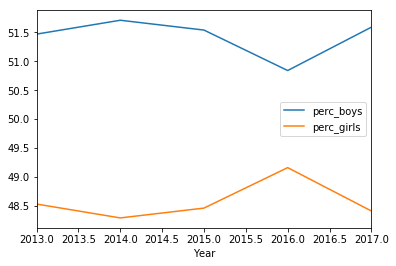

In [27]:
result.index = result.Year
result.drop(['Year'],axis=1,inplace=True)
result.plot()